# Remote sensing of soils on the farm: Is it feasible?
_an agile approach to scaleable system development_

## FOCUS: Research question(s) and scope
Within context defined in the [ReadMe document](/ReadMe-2.md), the FOCUS of this first test is to understand the given technology, essentially:

1. the Flower Power Soil sensor;
2. the Flower Power app for iPhone;
3. the data files that flow from iPhone app to cloud, and back to user desktop via Python script developed & maintained by GROW Observatory for the duration of this project; and
4. the GROW observatory hub website, as a source of end-user information and support.


Given that: 

- The sensor and iPhone app (1&2 above) work essentially as advertised, though there are some doubts about sensor weatherproofing [1]; and
- The [GROW Observatory website](https://hub.growobservatory.org/my-data/sensors/) (4 above; login required) gives a marginally useful but limited view of sensor data, and discussion forums that have yet to shape-up into a very good source of collegial exchange/ support;
- Our focus at this point is on the data files -now holding raw data uploaded from all our sensors, downloadable on demand as a set of .csv files (one per sensor) - and figuring out the information held in these files can be leveraged to add value to our farm operations.

QUESTION(S) for Research:
- DataFlow: Can we in fact dowload the data easily enough, in a form that we can work with using Pandas (since Python is the language of data tranfer script, this is the lingua franca)?
- Data Model: What indicators are available for tracking?
- Data Latency:  From time of upload, how quickly is data available for download?  And what if any is the maxium latency between recorded time of last record, and time of data upload?
- Data Integrity: Is the data complete (since sensor boot-up time, with no null values) and accurate (does it appear to make sense, as compared with what's known about local conditions)?

SCOPE: For the purposes of this analysis, data from one sensor (implanted 1 month ago) will be sufficient.  Data from several additional sensors that have since been implanted will be included in subsequent analysis (test2), once the questions above have been answered.

In [1]:
import pandas as pd   #load the software
print("Pandas version ",pd.__version__)  # confirm software version, to guarantee reproducible results

Pandas version  0.23.0


In [2]:
# Import the .csv datafile from the "test1" sensor, 
# convert the "capture_datetime_utc" column to parse those strings into useful datetime format
# change index to be that column (versus the assigned ID that is pandas default)
# ask pandas to confirm that the index of this file is now of datetime type
df=pd.read_csv("Flower power 6A22.csv",parse_dates=["capture_datetime_utc"], index_col="capture_datetime_utc")
type(df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [3]:
print("Customers: Rows & Columns = ",df.shape)  #to give an idea the shape of dataframe, literally
print("Customers: Column Headers: ",df.columns)  # to see the column headers

Customers: Rows & Columns =  (2866, 4)
Customers: Column Headers:  Index(['fertilizer_level', 'light', 'soil_moisture_percent',
       'air_temperature_celsius'],
      dtype='object')


In [4]:
df.head()   #so we can eyeball the first few rows of data
# df.iloc[0:5]   #another way of calling for those same rows by their originally indexed location

,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
capture_datetime_utc,,,,
2018-06-18 19:05:28,0.94,1.22,17.71,26.51
2018-06-18 19:20:28,0.94,0.91,17.59,26.15
2018-06-18 19:35:28,0.94,0.54,17.21,25.92
2018-06-18 19:50:28,0.94,0.18,17.46,25.83
2018-06-18 20:05:28,0.94,0.10,17.58,25.83


In [5]:
df.tail()  #this gives last few records, so we can confirm last update and continuity of update intervals

,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
capture_datetime_utc,,,,
2018-07-18 14:18:29,0.8,17.10,14.37,30.94
2018-07-18 14:33:29,0.8,17.75,14.11,31.12
2018-07-18 14:48:29,0.8,18.43,14.36,31.56
2018-07-18 15:03:29,0.8,19.04,14.23,30.85
2018-07-18 15:18:29,0.8,19.37,14.23,31.25


In [6]:
df.describe()  #gives a summary of descriptive statistics for the dataframe across all columns

,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
count,2866.000000,2866.000000,2866.000000,2866.000000
mean,0.821089,16.893140,16.998552,25.601989
std,0.120455,37.332312,7.412239,7.065481
min,0.660000,0.100000,5.740000,17.580000
25%,0.750000,0.100000,11.320000,20.830000
50%,0.780000,1.765000,16.575000,22.540000
75%,0.850000,15.292500,22.920000,28.850000
max,1.110000,171.240000,46.370000,54.920000


In [11]:
df["2018-07-17"].soil_moisture_percent.mean()  #average moisture reading as of yesterday (last full day)

18.906666666666652

In [8]:
df.soil_moisture_percent.resample('D').mean()  #daily average moisture readings since startup

capture_datetime_utc
2018-06-18    17.437500
2018-06-19    22.551354
2018-06-20    26.030833
2018-06-21    26.398229
2018-06-22    27.647917
2018-06-23    31.011667
2018-06-24    26.591042
2018-06-25    24.559792
2018-06-26    21.068646
2018-06-27    17.996250
2018-06-28    15.341771
2018-06-29    12.874479
2018-06-30    14.465521
2018-07-01    12.076354
2018-07-02    16.002396
2018-07-03    15.727083
2018-07-04    16.280729
2018-07-05    13.745104
2018-07-06    17.121771
2018-07-07    15.501250
2018-07-08    10.003958
2018-07-09    10.459375
2018-07-10     8.346875
2018-07-11     7.166146
2018-07-12     6.523438
2018-07-13     6.137396
2018-07-14    16.540521
2018-07-15    20.634062
2018-07-16    15.160000
2018-07-17    18.906667
2018-07-18    16.992258
Freq: D, Name: soil_moisture_percent, dtype: float64

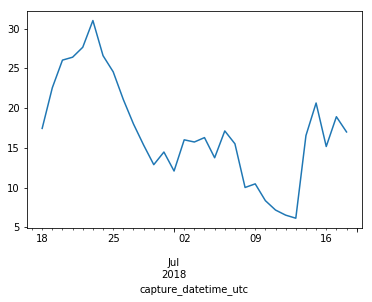

In [9]:
%matplotlib inline
df.soil_moisture_percent.resample('D').mean().plot(kind='line')
# a graphical plot of those daily average moisture values

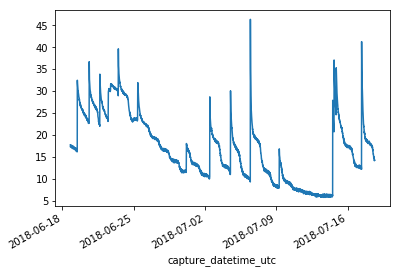

In [10]:
%matplotlib inline
df.soil_moisture_percent.plot(kind='line')
# a plot of that moisture history with full granularity (i.e. 15-min intervals)

![img source](SoilSensor,iPhoneData2.JPG)

![img source](https://i.imgur.com/l2XOgOGh.png)

# CONCLUSIONS notes and questions for further study

## NOTES
[1] There is a doubt about the impermeability of the battery compartment